In [1]:
import time 
# print current time 
print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")

Current time: 2025-05-24 17:08:43


In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [3]:
TARGET_KEY_BYTE_INDEX = 2 
N_SPLITS_CV = 10
MAX_TRACES_CV_EVAL = 1000
CV_EVAL_TRACE_STEP = 10
N_TOP_FEATURES = 100
PLOT_MAX_ATTACK_TRACES = 500  
RANDOM_STATE = 42
N_ESTIMATORS_RF = 100
MAX_DEPTH_RF = 20
MIN_SAMPLES_LEAF_RF = 10


In [4]:
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
], dtype=np.uint8)

In [ ]:
def load_ascad_dataset(file_path, target_key_byte_idx, load_profiling=True, load_attack=True): # Added flags
    profiling_traces, profiling_labels = None, None
    attack_traces, attack_plaintexts, true_key_byte_for_attack = None, None, None

    with h5py.File(file_path, "r") as f:
        if load_profiling:
            profiling_traces = f["Profiling_traces/traces"][:]
            profiling_labels = f["Profiling_traces/labels"][:] 
        
        if load_attack:
            attack_traces = f["Attack_traces/traces"][:]
            _ = f["Attack_traces/labels"][:] 
            attack_plaintexts = f["Attack_traces/metadata"]["plaintext"][:].astype(np.uint8)
            true_key_byte_for_attack = int(f["Attack_traces/metadata"]["key"][0][target_key_byte_idx])
            
    return profiling_traces, profiling_labels, attack_traces, attack_plaintexts, true_key_byte_for_attack


ASCAD_VARIABLE_KEY_FILE_PATH = "ASCADVariable.h5" # <<< --- !!! UPDATE THIS PATH !!!

print("--- Loading ASCAD Variable Key (ASCADv) Data ---")

X_profiling_raw_v, y_profiling_v, X_attack_raw_v, attack_plaintexts_v, true_key_byte_v = load_ascad_dataset(
    ASCAD_VARIABLE_KEY_FILE_PATH, TARGET_KEY_BYTE_INDEX, load_profiling=True, load_attack=True
)
print(f"Successfully loaded ASCAD Variable Key dataset from: {ASCAD_VARIABLE_KEY_FILE_PATH}")
print(f"True key byte for ASCADv attack set: {true_key_byte_v} (0x{true_key_byte_v:02X})")
print(f"ASCADv Profiling traces shape: {X_profiling_raw_v.shape}, Labels: {y_profiling_v.shape}")
print(f"ASCADv Attack traces shape: {X_attack_raw_v.shape}, Plaintexts: {attack_plaintexts_v.shape}")

# Scale ASCADv data
scaler_v = StandardScaler()
X_profiling_scaled_v = scaler_v.fit_transform(X_profiling_raw_v)
X_attack_scaled_v = scaler_v.transform(X_attack_raw_v)
print("ASCADv Data scaled using its profiling set statistics.")

In [8]:
# Slightly modified and detailed than the CNN version
def compute_key_rank(model, attack_traces, plaintexts, true_key_value,
                     n_traces_for_rank, sbox_array, target_plaintext_byte_idx,
                     epsilon=1e-12, precomputed_probs=None):
    
    num_available_traces_total = plaintexts.shape[0]
    # Ensure we don't try to use more traces than available or more than specified for this rank computation
    n_traces_to_use = min(n_traces_for_rank, num_available_traces_total)

    if n_traces_to_use == 0:
        return 255, np.zeros(256) # Max rank (worst) if no traces are used

    # Get probabilities from the model for the selected traces
    if precomputed_probs is None:
        probabilities = model.predict_proba(attack_traces[:n_traces_to_use])
    else:
        if precomputed_probs.shape[0] < n_traces_to_use:
            raise ValueError(f"Precomputed_probs has {precomputed_probs.shape[0]} traces, but {n_traces_to_use} are needed.")
        probabilities = precomputed_probs[:n_traces_to_use]
    
    # Ensure probabilities are valid and normalized (sum to 1 per trace)
    probabilities = np.maximum(probabilities, epsilon) # Prevent log(0)
    row_sums = probabilities.sum(axis=1, keepdims=True)
    # Avoid division by zero if a row_sum is zero (e.g. all probabilities were < epsilon and got floored)
    probabilities = np.divide(probabilities, row_sums, out=np.zeros_like(probabilities), where=row_sums!=0)


    key_log_likelihoods = np.zeros(256) # Log-likelihood scores for each key hypothesis

    for key_guess in range(256):
        # Calculate S-box(plaintext_byte ^ key_guess) for all traces uand ensure plaintexts array is also sliced to n_traces_to_use
        intermediate_values = sbox_array[plaintexts[:n_traces_to_use, target_plaintext_byte_idx] ^ key_guess]

        # P(Trace_i | Sbox_out_k_guess) = probabilities[i, Sbox_out_k_guess_for_trace_i]
        trace_specific_probabilities = probabilities[np.arange(n_traces_to_use), intermediate_values]
        
        # Sum the log-probabilities 
        key_log_likelihoods[key_guess] = np.sum(np.log(trace_specific_probabilities))

    # Rank keys by their log-likelihood
    ranked_key_indices = np.argsort(key_log_likelihoods)[::-1] # Descending order

    true_key_rank = np.where(ranked_key_indices == true_key_value)[0][0]

    return true_key_rank, key_log_likelihoods


In [9]:
# ## Helper Functions for Model Evaluation and Plotting

def plot_key_rank_vs_traces(trace_counts, ranks, model_name, color='blue', linestyle='-',marker='o'):
    plt.plot(trace_counts[:len(ranks)], ranks, marker=marker, linestyle=linestyle, label=model_name, color=color)

def plot_key_score_distribution(scores, predicted_key, true_key, model_name, num_traces, color='gray'):
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(256), scores, color=color)
    plt.axvline(predicted_key, color='g', linestyle='--', label=f"Predicted = {predicted_key} (0x{predicted_key:02X})")
    plt.axvline(true_key, color='r', linestyle='--', label=f"True = {true_key} (0x{true_key:02X})")
    plt.xlabel("Key Byte Guess")
    plt.ylabel("Log-Likelihood Score")
    plt.title(f"{model_name} Key Score Distribution after {num_traces} Attack Traces")
    plt.legend()
    plt.show()

def print_top_key_candidates(scores, true_key, model_name, top_n=5):
    ranked_key_indices = np.argsort(scores)[::-1] # Highest score first
    print(f"\nTop {top_n} Key Candidates for {model_name} (Rank, Key Byte, Hex, Score):")
    print(f"{'Rank':<5} {'Key Byte':<10} {'Hex':<5} {'Log-Likelihood':<15}")
    print("-" * 45)
    for i in range(min(top_n, 256)):
        key_byte_val = ranked_key_indices[i]
        score_val = scores[key_byte_val]
        true_marker = " <<< TRUE KEY" if key_byte_val == true_key else ""
        print(f"{i:<5} {key_byte_val:<10} {f'0x{key_byte_val:02X}':<5} {score_val:<15.4f}{true_marker}")
    print("-" * 45)

def evaluate_model_performance(model, model_name, X_attack_eval, plaintexts_eval,
                               true_key_eval, sbox_eval, target_plaintext_idx_eval,
                               max_traces_plot, plot_step_eval):
    #Evaluates a trained model by computing key rank progression and key score distribution.
    print(f"\n--- Evaluating {model_name} Model on Attack Set ---")
    
    ranks_for_plot = []
    
    effective_max_traces_for_eval = min(max_traces_plot, X_attack_eval.shape[0])
    # Create trace counts for plotting, ensuring the effective_max_traces is included
    trace_counts_for_plot = list(range(0, effective_max_traces_for_eval + 1, plot_step_eval))
    if effective_max_traces_for_eval > 0 and effective_max_traces_for_eval not in trace_counts_for_plot:
        if not trace_counts_for_plot or effective_max_traces_for_eval > trace_counts_for_plot[-1]:
            trace_counts_for_plot.append(effective_max_traces_for_eval)
        trace_counts_for_plot.sort()
    if not trace_counts_for_plot and effective_max_traces_for_eval == 0: # Handle case of 0 attack traces
        trace_counts_for_plot = [0]


    print(f"Calculating Key Rank vs. Traces for {model_name} model (up to {effective_max_traces_for_eval} traces)...")
    
    all_attack_set_probs = None
    if X_attack_eval.shape[0] > 0: # Only predict if there are attack traces
        print(f"Precomputing probabilities for {X_attack_eval.shape[0]} attack traces using {model_name}...")
        start_prob_time_eval = time.time()
        all_attack_set_probs = model.predict_proba(X_attack_eval)
        end_prob_time_eval = time.time()
        print(f"Probability precomputation finished. Duration: {end_prob_time_eval - start_prob_time_eval:.2f} seconds")

    for n_tr in trace_counts_for_plot:
        if n_tr == 0:
            ranks_for_plot.append(255) 
            continue
        
        current_eval_n_traces = min(n_tr, effective_max_traces_for_eval)
        
        if current_eval_n_traces == 0 or all_attack_set_probs is None:
            ranks_for_plot.append(255)
            continue

        rank, _ = compute_key_rank(
            model=model,
            attack_traces=X_attack_eval, 
            plaintexts=plaintexts_eval,
            true_key_value=true_key_eval,
            n_traces_for_rank=current_eval_n_traces,
            sbox_array=sbox_eval,
            target_plaintext_byte_idx=target_plaintext_idx_eval,
            precomputed_probs=all_attack_set_probs 
        )
        ranks_for_plot.append(rank)
    print("Finished calculating ranks for plot.")
    
    # --- Key Score Distribution Data ---
    num_traces_for_final_scores = min(max_traces_plot, X_attack_eval.shape[0])
    
    final_key_scores = np.zeros(256)
    if num_traces_for_final_scores > 0 and all_attack_set_probs is not None:
        probs_for_scores = all_attack_set_probs[:num_traces_for_final_scores]
        _, final_key_scores = compute_key_rank(
            model=model,
            attack_traces=X_attack_eval, 
            plaintexts=plaintexts_eval,
            true_key_value=true_key_eval,
            n_traces_for_rank=num_traces_for_final_scores,
            sbox_array=sbox_eval,
            target_plaintext_byte_idx=target_plaintext_idx_eval,
            precomputed_probs=probs_for_scores
        )

    predicted_key_byte_val = int(np.argmax(final_key_scores)) if num_traces_for_final_scores > 0 else 0
    print(f"\n--- {model_name} Model Key Score Analysis (using {num_traces_for_final_scores} traces) ---")
    print(f"{model_name} Model's predicted key byte = {predicted_key_byte_val} (0x{predicted_key_byte_val:02X})")
    print(f"True key byte (for evaluation only) = {true_key_eval} (0x{true_key_eval:02X})")
    print("Attack successful!" if predicted_key_byte_val == true_key_eval else "Attack failed.")

        
    return ranks_for_plot, trace_counts_for_plot, final_key_scores, predicted_key_byte_val, num_traces_for_final_scores


--- Training Final Random Forest Model on ALL ASCADv Profiling Data ---


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  3.6min


Final RF model (trained on ASCADv) training finished.

--- Evaluating Final RF (Trained on ASCADv, Attack ASCADv) Model on Attack Set ---
Calculating Key Rank vs. Traces for Final RF (Trained on ASCADv, Attack ASCADv) model (up to 1000 traces)...
Precomputing probabilities for 100000 attack traces using Final RF (Trained on ASCADv, Attack ASCADv)...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   14.0s


Probability precomputation finished. Duration: 29.54 seconds
Finished calculating ranks for plot.

--- Final RF (Trained on ASCADv, Attack ASCADv) Model Key Score Analysis (using 1000 traces) ---
Final RF (Trained on ASCADv, Attack ASCADv) Model's predicted key byte = 34 (0x22)
True key byte (for evaluation only) = 34 (0x22)
Attack successful!


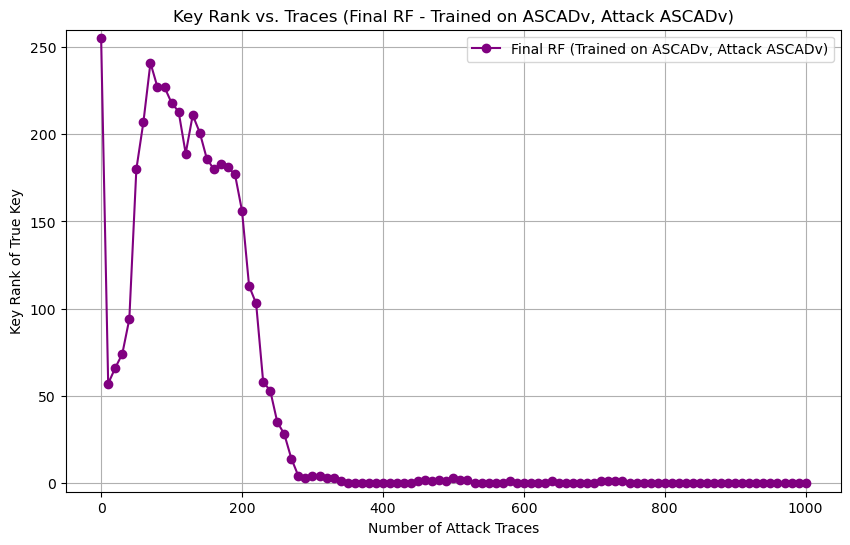

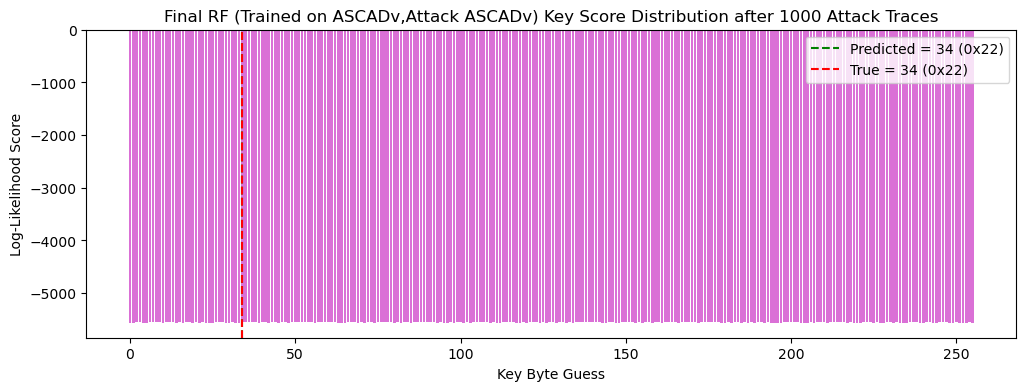


Top 5 Key Candidates for Final RF (Trained on ASCADv, Attack ASCADv) (Rank, Key Byte, Hex, Score):
Rank  Key Byte   Hex   Log-Likelihood 
---------------------------------------------
0     34         0x22  -5539.5483      <<< TRUE KEY
1     38         0x26  -5541.1312     
2     107        0x6B  -5541.9846     
3     222        0xDE  -5542.1068     
4     206        0xCE  -5544.2607     
---------------------------------------------


In [11]:

#Random Forest: Final Model and Evaluation (on ASCAD Variable Key Data)

print("\n--- Training Final Random Forest Model on ALL ASCADv Profiling Data ---")
rf_final_model_v = RandomForestClassifier(
    n_estimators=N_ESTIMATORS_RF,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_depth=MAX_DEPTH_RF,
    min_samples_leaf=MIN_SAMPLES_LEAF_RF,
    verbose=1 # Show some training progress
)
rf_final_model_v.fit(X_profiling_scaled_v, y_profiling_v) # Train on ASCADv data
print("Final RF model (trained on ASCADv) training finished.")

# Evaluate the final RF model trained on ASCADv
rf_final_ranks_v, rf_final_trace_counts_v, rf_final_scores_v, rf_final_pred_key_v, rf_final_num_traces_scores_v = evaluate_model_performance(
    model=rf_final_model_v,
    model_name="Final RF (Trained on ASCADv, Attack ASCADv)",
    X_attack_eval=X_attack_scaled_v,         # Use ASCADv attack traces
    plaintexts_eval=attack_plaintexts_v,     # Use ASCADv attack plaintexts
    true_key_eval=true_key_byte_v,           # Use ASCADv attack true key
    sbox_eval=SBOX,
    target_plaintext_idx_eval=TARGET_KEY_BYTE_INDEX,
    max_traces_plot=1000,#Changed it manually to 1000 because rank 0 was achieved after 500 traces in earlier runs
    plot_step_eval=10
)

# Plot results for Final RF Model (trained on ASCADv)
plt.figure(figsize=(10, 6)) 
plot_key_rank_vs_traces(rf_final_trace_counts_v, rf_final_ranks_v, 
                        "Final RF (Trained on ASCADv, Attack ASCADv)", color='purple')
plt.xlabel("Number of Attack Traces")
plt.ylabel("Key Rank of True Key")
plt.title("Key Rank vs. Traces (Final RF - Trained on ASCADv, Attack ASCADv)")
plt.grid(True)
plt.ylim(-5, 260)
plt.legend()
plt.show()

plot_key_score_distribution(rf_final_scores_v, rf_final_pred_key_v, true_key_byte_v, "Final RF (Trained on ASCADv,Attack ASCADv)", rf_final_num_traces_scores_v, color='orchid')
print_top_key_candidates(rf_final_scores_v, true_key_byte_v,"Final RF (Trained on ASCADv, Attack ASCADv)")



--- Feature Importance Analysis (Final RF Model trained on ASCADv) ---
Top 15 most important time points (features) from ASCADv-trained RF Model:
1. Time Point Index: 1071 (Importance: 0.0044)
2. Time Point Index: 188 (Importance: 0.0041)
3. Time Point Index: 187 (Importance: 0.0038)
4. Time Point Index: 1070 (Importance: 0.0036)
5. Time Point Index: 1074 (Importance: 0.0032)
6. Time Point Index: 1072 (Importance: 0.0031)
7. Time Point Index: 1066 (Importance: 0.0030)
8. Time Point Index: 1069 (Importance: 0.0030)
9. Time Point Index: 1067 (Importance: 0.0028)
10. Time Point Index: 189 (Importance: 0.0027)
11. Time Point Index: 62 (Importance: 0.0027)
12. Time Point Index: 1075 (Importance: 0.0026)
13. Time Point Index: 439 (Importance: 0.0026)
14. Time Point Index: 63 (Importance: 0.0026)
15. Time Point Index: 1068 (Importance: 0.0025)


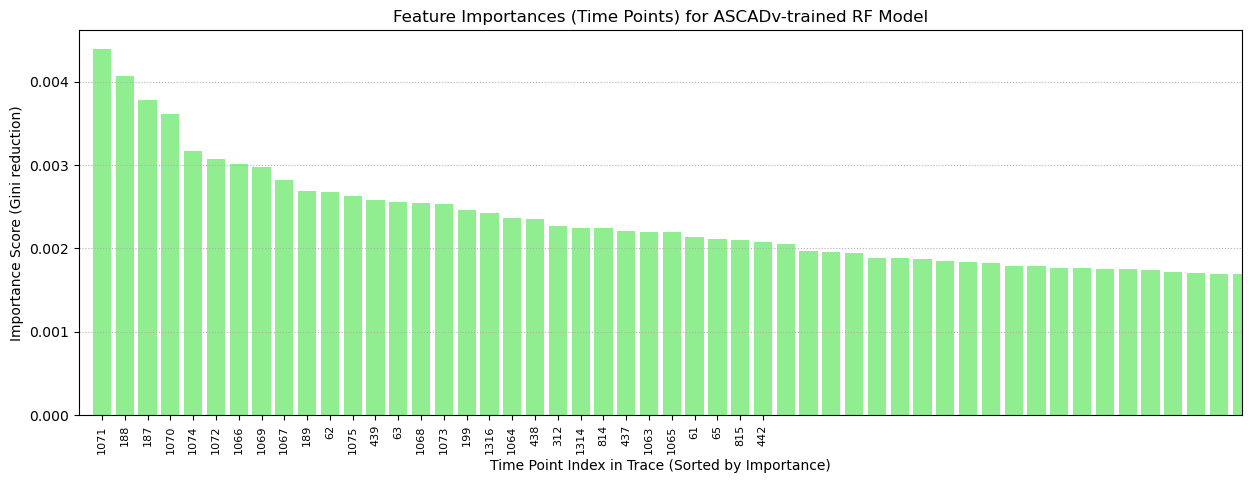


--- Selecting Top 100 Features based on ASCADv-trained RF Model ---


Reduced ASCADv Profiling Training Set shape: (200000, 100)
Reduced ASCADv Attack Set shape: (100000, 100)

--- Training RF Model on Top 100 Features (from ASCADv profiling) ---


RF model training on reduced ASCADv features finished.

--- Evaluating RF Reduced (100 features, Trained on ASCADv) Model on Attack Set ---
Calculating Key Rank vs. Traces for RF Reduced (100 features, Trained on ASCADv) model (up to 500 traces)...
Precomputing probabilities for 100000 attack traces using RF Reduced (100 features, Trained on ASCADv)...


Probability precomputation finished. Duration: 14.84 seconds


Finished calculating ranks for plot.

--- RF Reduced (100 features, Trained on ASCADv) Model Key Score Analysis (using 500 traces) ---
RF Reduced (100 features, Trained on ASCADv) Model's predicted key byte = 34 (0x22)
True key byte (for evaluation only) = 34 (0x22)
Attack successful!


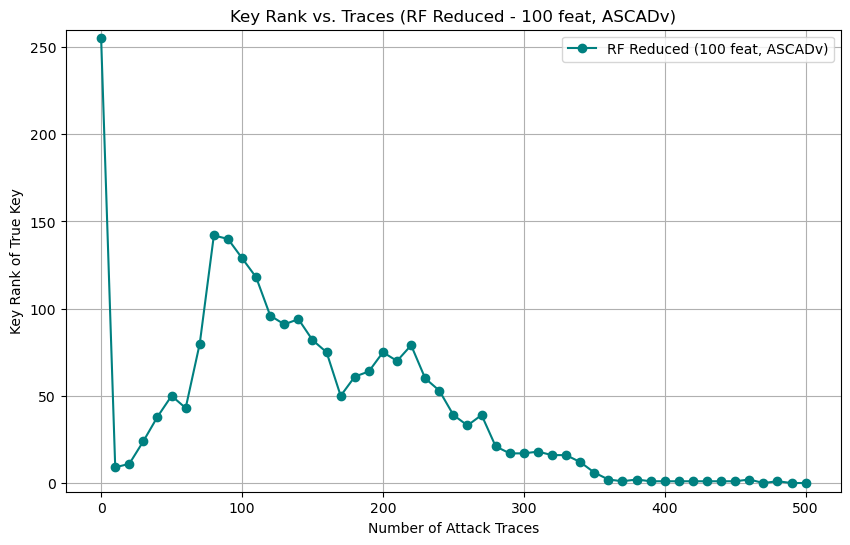

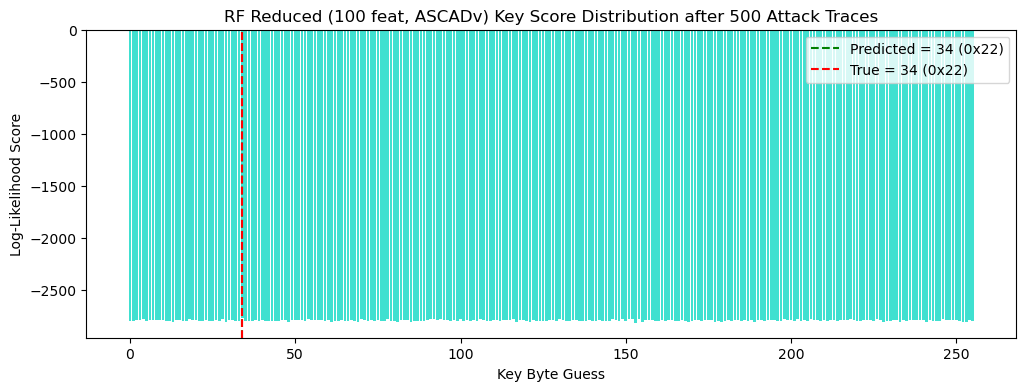


Top 5 Key Candidates for RF Reduced (100 feat, ASCADv) (Rank, Key Byte, Hex, Score):
Rank  Key Byte   Hex   Log-Likelihood 
---------------------------------------------
0     34         0x22  -2772.6649      <<< TRUE KEY
1     154        0x9A  -2774.9477     
2     100        0x64  -2775.8634     
3     202        0xCA  -2775.9208     
4     28         0x1C  -2776.9434     
---------------------------------------------


In [10]:
# Random Forest: Feature Selection and Evaluation (on ASCAD Variable Key Data)

print("\n--- Feature Importance Analysis (Final RF Model trained on ASCADv) ---")
importances_v = rf_final_model_v.feature_importances_
indices_v = np.argsort(importances_v)[::-1] # Sort features by importance
num_features_total_v = X_profiling_scaled_v.shape[1]

print(f"Top 15 most important time points (features) from ASCADv-trained RF Model:")
for i in range(min(15, num_features_total_v)):
    print(f"{i + 1}. Time Point Index: {indices_v[i]} (Importance: {importances_v[indices_v[i]]:.4f})")

plt.figure(figsize=(15, 5))
plt.title("Feature Importances (Time Points) for ASCADv-trained RF Model")
plt.bar(range(num_features_total_v), importances_v[indices_v], color="lightgreen", align="center") 
num_ticks_to_show_v = min(30, num_features_total_v) 
plt.xticks(range(num_ticks_to_show_v), indices_v[:num_ticks_to_show_v], rotation=90, fontsize=8)
plt.xlabel("Time Point Index in Trace (Sorted by Importance)")
plt.ylabel("Importance Score (Gini reduction)")
plt.xlim([-1, min(50, num_features_total_v)]) 
plt.grid(axis='y', linestyle=':')
plt.show()

print(f"\n--- Selecting Top {N_TOP_FEATURES} Features based on ASCADv-trained RF Model ---")
top_k_indices_v = indices_v[:N_TOP_FEATURES]

X_profiling_reduced_v = X_profiling_scaled_v[:, top_k_indices_v]
X_attack_reduced_v = X_attack_scaled_v[:, top_k_indices_v] 

print(f"Reduced ASCADv Profiling Training Set shape: {X_profiling_reduced_v.shape}")
print(f"Reduced ASCADv Attack Set shape: {X_attack_reduced_v.shape}")

print(f"\n--- Training RF Model on Top {N_TOP_FEATURES} Features (from ASCADv profiling) ---")
rf_reduced_model_v = RandomForestClassifier(
    n_estimators=N_ESTIMATORS_RF,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_depth=MAX_DEPTH_RF,
    min_samples_leaf=MIN_SAMPLES_LEAF_RF,
    verbose=0 
)
rf_reduced_model_v.fit(X_profiling_reduced_v, y_profiling_v) # Train on reduced ASCADv profiling
print("RF model training on reduced ASCADv features finished.")

# Evaluate the RF model on reduced ASCADv features, attacking ASCADv attack set
rf_reduced_ranks_v, rf_reduced_trace_counts_v, rf_reduced_scores_v, \
rf_reduced_pred_key_v, rf_reduced_num_traces_scores_v = evaluate_model_performance(
    model=rf_reduced_model_v,
    model_name=f"RF Reduced ({N_TOP_FEATURES} features, Trained on ASCADv)",
    X_attack_eval=X_attack_reduced_v,       # Use reduced ASCADv attack
    plaintexts_eval=attack_plaintexts_v,   # Use ASCADv attack plaintexts
    true_key_eval=true_key_byte_v,         # Use ASCADv attack true key
    sbox_eval=SBOX,
    target_plaintext_idx_eval=TARGET_KEY_BYTE_INDEX,
    max_traces_plot=PLOT_MAX_ATTACK_TRACES,
    plot_step_eval=10
)

# Plot results for Reduced RF Model (trained on ASCADv)
plt.figure(figsize=(10, 6)) # Create a new figure
plot_key_rank_vs_traces(rf_reduced_trace_counts_v, rf_reduced_ranks_v, 
                        f"RF Reduced ({N_TOP_FEATURES} feat, ASCADv)", color='teal')
plt.xlabel("Number of Attack Traces")
plt.ylabel("Key Rank of True Key")
plt.title(f"Key Rank vs. Traces (RF Reduced - {N_TOP_FEATURES} feat, ASCADv)")
plt.grid(True)
plt.ylim(-5, 260)
plt.legend()
plt.show()

plot_key_score_distribution(rf_reduced_scores_v, rf_reduced_pred_key_v, true_key_byte_v,
                                f"RF Reduced ({N_TOP_FEATURES} feat, ASCADv)", 
                                rf_reduced_num_traces_scores_v, color='turquoise')
print_top_key_candidates(rf_reduced_scores_v, true_key_byte_v, 
                            f"RF Reduced ({N_TOP_FEATURES} feat, ASCADv)")



--- Training SVM (SVC) Model on ALL ASCADv Profiling Data ---
Training SVC model on the top 100 features from ASCADv profiling data
Reduced ASCADv Profiling Training Set shape: (200000, 100)
Reduced ASCADv Attack Set shape: (100000, 100)
Training SVC model on ASCADv data (this may take a while)...


SVC model training completed in 43732.49 seconds.

--- Evaluating SVC (100 features, Trained on ASCADv) Model on Attack Set ---
Calculating Key Rank vs. Traces for SVC (100 features, Trained on ASCADv) model (up to 500 traces)...
Precomputing probabilities for 100000 attack traces using SVC (100 features, Trained on ASCADv)...


Probability precomputation finished. Duration: 13424.46 seconds


Finished calculating ranks for plot.

--- SVC (100 features, Trained on ASCADv) Model Key Score Analysis (using 500 traces) ---
SVC (100 features, Trained on ASCADv) Model's predicted key byte = 34 (0x22)
True key byte (for evaluation only) = 34 (0x22)
Attack successful!


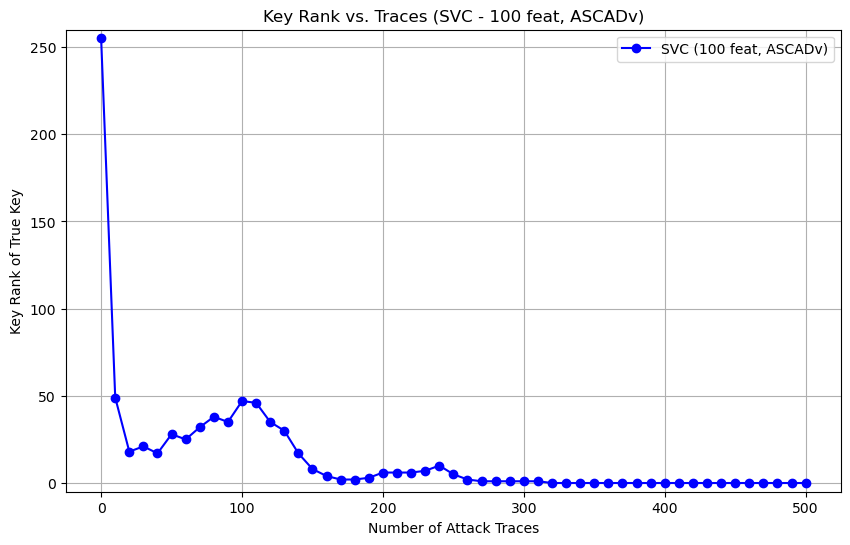

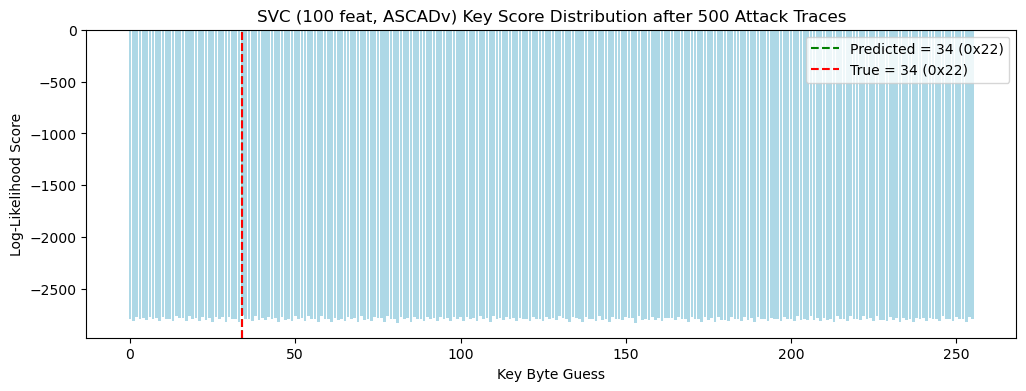


Top 5 Key Candidates for SVC (100 feat, ASCADv) (Rank, Key Byte, Hex, Score):
Rank  Key Byte   Hex   Log-Likelihood 
---------------------------------------------
0     34         0x22  -2751.2366      <<< TRUE KEY
1     154        0x9A  -2755.5227     
2     110        0x6E  -2756.3411     
3     106        0x6A  -2758.2242     
4     70         0x46  -2758.7850     
---------------------------------------------


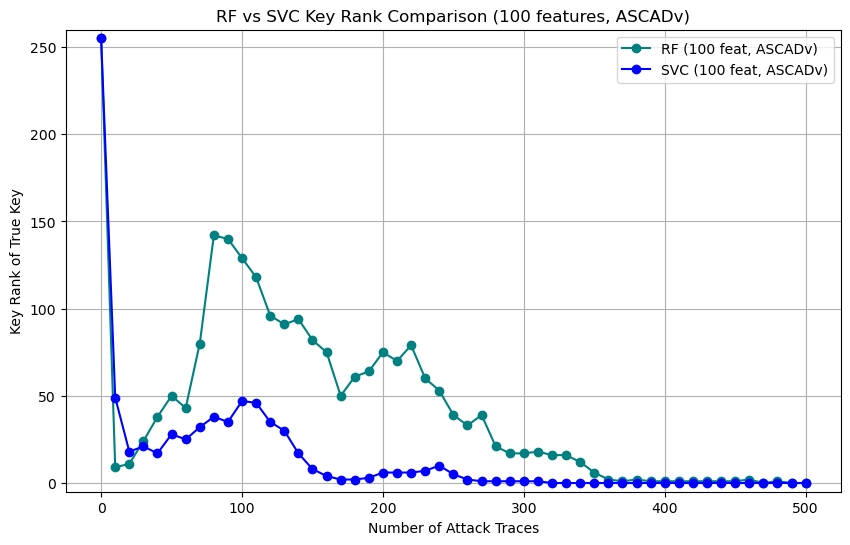

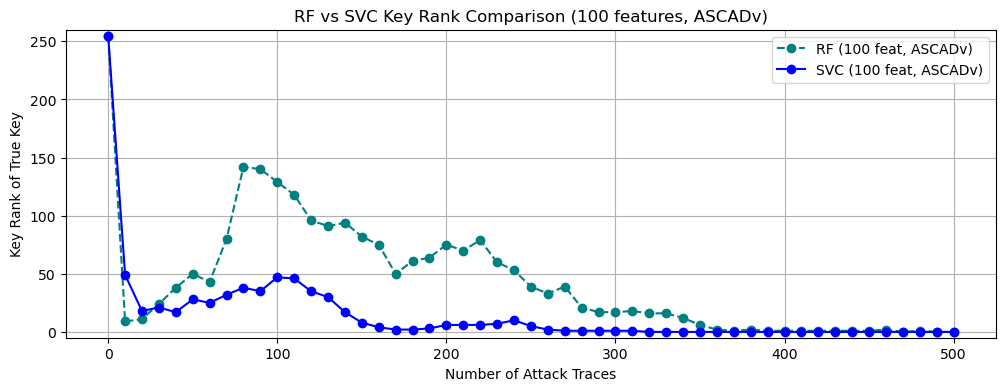

In [12]:
# SVC On ASCAD Variable Key Dataset

print("\n--- Training SVM (SVC) Model on ALL ASCADv Profiling Data ---")
# Start with reduced feature set since SVC trains slower with high dimensions
print(f"Training SVC model on the top {N_TOP_FEATURES} features from ASCADv profiling data")

# Check if feature selection was already done, if not, do it now
if 'top_k_indices_v' not in locals():
	print("Performing feature importance analysis first...")
	rf_temp = RandomForestClassifier(
		n_estimators=N_ESTIMATORS_RF, 
		random_state=RANDOM_STATE, 
		n_jobs=-1,
		max_depth=MAX_DEPTH_RF,
		min_samples_leaf=MIN_SAMPLES_LEAF_RF,
		verbose=False
	)
	rf_temp.fit(X_profiling_scaled_v, y_profiling_v)
	importances_v = rf_temp.feature_importances_
	indices_v = np.argsort(importances_v)[::-1]  # Sort features by importance
	top_k_indices_v = indices_v[:N_TOP_FEATURES]
	X_profiling_reduced_v = X_profiling_scaled_v[:, top_k_indices_v]
	X_attack_reduced_v = X_attack_scaled_v[:, top_k_indices_v]
	
print(f"Reduced ASCADv Profiling Training Set shape: {X_profiling_reduced_v.shape}")
print(f"Reduced ASCADv Attack Set shape: {X_attack_reduced_v.shape}")

svc_model_v = SVC(
	kernel='rbf',  # Radial Basis Function kernel
	probability=True,  # Enable probability estimates, needed for key rank computation
	random_state=RANDOM_STATE,
	C=1,  
	gamma='scale', 
	verbose=False
)

start_time = time.time()
print("Training SVC model on ASCADv data (this may take a while)...")
svc_model_v.fit(X_profiling_reduced_v, y_profiling_v)
end_time = time.time()
print(f"SVC model training completed in {end_time - start_time:.2f} seconds.")

# Evaluate the SVC model on reduced features
svc_ranks_v, svc_trace_counts_v, svc_scores_v, \
svc_pred_key_v, svc_num_traces_scores_v = evaluate_model_performance(
	model=svc_model_v,
	model_name=f"SVC ({N_TOP_FEATURES} features, Trained on ASCADv)",
	X_attack_eval=X_attack_reduced_v,       # Use reduced ASCADv attack
	plaintexts_eval=attack_plaintexts_v,    # Use ASCADv attack plaintexts
	true_key_eval=true_key_byte_v,          # Use ASCADv attack true key
	sbox_eval=SBOX,
	target_plaintext_idx_eval=TARGET_KEY_BYTE_INDEX,
	max_traces_plot=PLOT_MAX_ATTACK_TRACES,
	plot_step_eval=10
)

# Plot results for SVC Model
plt.figure(figsize=(10, 6))
plot_key_rank_vs_traces(svc_trace_counts_v, svc_ranks_v, 
						f"SVC ({N_TOP_FEATURES} feat, ASCADv)", color='blue')
plt.xlabel("Number of Attack Traces")
plt.ylabel("Key Rank of True Key")
plt.title(f"Key Rank vs. Traces (SVC - {N_TOP_FEATURES} feat, ASCADv)")
plt.grid(True)
plt.ylim(-5, 260)
plt.legend()
plt.show()

plot_key_score_distribution(svc_scores_v, svc_pred_key_v, true_key_byte_v,
							f"SVC ({N_TOP_FEATURES} feat, ASCADv)", 
							svc_num_traces_scores_v, color='lightblue')
print_top_key_candidates(svc_scores_v, true_key_byte_v, 
						f"SVC ({N_TOP_FEATURES} feat, ASCADv)")

# Compare RF and SVC performance if both are available
if 'rf_reduced_ranks_v' in locals():
	plt.figure(figsize=(10, 6))
	plot_key_rank_vs_traces(rf_reduced_trace_counts_v, rf_reduced_ranks_v, 
							f"RF ({N_TOP_FEATURES} feat, ASCADv)", color='teal')
	plot_key_rank_vs_traces(svc_trace_counts_v, svc_ranks_v, 
							f"SVC ({N_TOP_FEATURES} feat, ASCADv)", color='blue')
	plt.xlabel("Number of Attack Traces")
	plt.ylabel("Key Rank of True Key")
	plt.title(f"RF vs SVC Key Rank Comparison ({N_TOP_FEATURES} features, ASCADv)")
	plt.grid(True)
	plt.ylim(-5, 260)
	plt.legend()
	plt.show()
